# Introduction
This tutorial will give an example application of using deep learning for medical image segmentation. This example will demonstrate how to train a convolutional neural network for the purpose of lung segmentation in CT images. The tutorial will have 3 main parts:
1. Loading and examining data for model training
2. Creating, training, and evaluating a deep learning segmentation model
3. Making improvements to the model with skip connections

Keep an eye out for questions through this demo to test your new DL knowledge and critical thinking. There are answers at the end of the document.

### Initial preparation

Import necessary modules. We also need to install the Python package PyDicom

In [ ]:
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt # for plotting our results

# initialize random seeds for more reproducible results
numpy.random.seed(1)
tf.random.set_seed(1)

!pip install pydicom

Next, we need to copy the files to a place where our CoLab notebook can read them.

In [ ]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copy data to this VM
import tarfile
from tqdm import tqdm
with tarfile.open(name='/content/drive/My Drive/ML4MI_BOOTCAMP_DATA/ImageSegmentation.tar') as tar:
    for member in tqdm(iterable=tar.getmembers(), desc='Decompressing', unit='file', total=len(tar.getmembers())):
      tar.extract(member=member,path='/home/')

# Change the working folder
%cd /home/ImageSegmentation
    
# Download helper function to this VM
!wget https://raw.githubusercontent.com/kmjohnson3/ML4MI_bootcamp/master/ImageSegmentation/Demo_Functions.py

# Part 1: Data Preparation
All deep learning applications start with getting the data. In this case, the data has already been collected from subjects through CT scans and annotations have been made.

Additionally, we have already created a function for loading in this data in an organized way and get it ready to feed into a deep learning model for training. The data is currently stored as DICOMs in a mess of directories. This function sorts through the directories and loads in the necessary images and masks.

Because we have already written this function, you can just import this function and load the data into our various needed arrays.

In [ ]:
from Demo_Functions import GetLungSegData

trainX,trainY,valX,valY = GetLungSegData('/home/ImageSegmentation/LCTSC')

Let's examine these arrays we've loaded.

In [ ]:
print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)

We have two sets of corresponding images and masks. There are 1299 slices of 256x256 images in the training set, and 144 in the validation set.

Each of these sets has a 4th dimension that has length 1. Why? Keras, and most other deep learning libraries, expects images to be in color. That is, they have R,G, and B color channels. So images are expected to be passed in as 4 dimensional arrays. In this case, we are passing in grayscale images, so they will just have a single color channel instead of three.

##### Question 1: What could be another use for having multiple input channels?
Hint: Think MRI.

At this point, it would be good to check that our data loaded correctly and the masks correspond to the input images. We'll using the python plotting package matplotlib to display a sample image and mask side by side for both the training and validation datasets.

It's a good idea to try several different display indices to make sure all your data is lined up correctly.

In [ ]:
# choose a single slice for display
disp_ind = 5

# make a figure
plt.figure()

# concatenate the input and target image together
disp = numpy.c_[trainX[disp_ind,...,0],
                trainY[disp_ind,...,0]]

# display image (with grayscale)
plt.imshow(disp,cmap='gray')
plt.show()

# repeat for validation set
disp_ind = 5

plt.figure()

# concatenate the input and target image together
disp = numpy.c_[valX[disp_ind,...,0],
                valY[disp_ind,...,0]]

# display image (with grayscale)
plt.imshow(disp,cmap='gray')
plt.show()

Looks good!

## Our data is now ready for training!

# Part 2: Building a segmentation network

We will build a deep convolutional neural network layer by layer, using Keras' high-level libraries that are relatively easy to work with to create exactly the network that we want.

For this segmentation problem, the most common and effective networks follow a style known as 'convolutional encoder-decoder' or CED. This means that using convolutional layers we will downsample, or 'encode', our input data, and then upsample, or 'encode' back to our original input size. In this way, the convolutional layers will learn to create a mapping of our input images into a segmentation mask.

Now, let's build a segmentation model!

First, import some layers we will use:

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ZeroPadding2D
# also, import the Model function for building the model
from tensorflow.keras.models import Model

We first need an input layer. Our input layer just needs the shape of the input we are providing. The shape dimensions are [sample,row,column,channel].

For this 2D network, our samples are different slices. We don't need to provide this dimension to the input layer, since we will feed those samples in as batches during training. But we need the rest of the dimensions.

Keep in mind that Python uses 0-indexing. So `[1:]` means collect all the parts of the array except the first one.

In [ ]:
# create our input layer by giving it an input shape
inp = Input(shape=trainX.shape[1:])

Now, we will add on convolutional layers

The syntax for adding layers to our network is:

`newlayer = LayerType(layer_parameters)(input_layer)`

   newlayer: the variable that stores the current output of the network.  
   LayerType: the type of the new layer we are adding onto the network, in this case Conv2D layers.  
   layer_parameters: the inputs we provide to define the new layer. For Conv2D layers, this is given as (number of filters, size of filters, and type of nonlinearity applied to the layer).  
   input_layer: the previous layer that our new layer is going to be connected to.
   
So for example: `x = Conv2D(10,(3,3), activation='relu')(inp)` creates a 2D convolutional layer with 10 filters that are 3x3 in size. The non-linearity (activation) is a Rectified Linear Unit, and it takes 'inp' as an input and gives its output as x.

Without further ado, let's make our CED network!

In [ ]:
# add on a couple convolutional layers
x = Conv2D(10,kernel_size=(3,3),padding='same',activation='relu')(inp)
x = Conv2D(20, kernel_size=(3,3),padding='same',activation='relu')(x)
# We will have to use some specific zero padding
# to keep our layer sizes friendly for this segmentation model
# make a zero padding layer that does 1 pad of zeros
# on all sides
x = ZeroPadding2D(padding=(1,1))(x)
# Add a strided convolution layer
x = Conv2D(30, kernel_size=(4,4),
                strides=(2,2),
                activation='relu')(x)
# Now repeat the process, hanging onto the second layer again
x = Conv2D(30, kernel_size=(3,3),padding='same',activation='relu')(x)
x = Conv2D(40, kernel_size=(3,3),padding='same',activation='relu')(x)
x = ZeroPadding2D(padding=(1,1))(x)
x = Conv2D(40, kernel_size=(4,4),
                strides=(2,2),
                activation='relu')(x)
# We've now done 2 downsampling layers, like before.
# Now for the decoding side of the network, we will start
# adding skip connections
# The first couple of layers are the same as usual.
x = Conv2D(50, kernel_size=(3,3),padding='same',activation='relu')(x)
x = Conv2D(50, kernel_size=(3,3),padding='same',activation='relu')(x)
# now, we will reverse the downsampling using Transposed Convolutions, also
# incorrectly but commonly called Deconvolution
from keras.layers import Conv2DTranspose
# This is now the decoding side of the network
# The syntax is identical. However, we need the decoding side of the network to end
# up with the same output size as our images, so the 
# precise order and size of layers matter
x = Conv2DTranspose(40, kernel_size=(4,4),
                        strides=(2,2),
                        activation='relu')(x)
# Mixing in regular Conv2D layers is sometimes necessary
# for getting layer shapes to work out
x = Conv2D(40, kernel_size=(3,3),activation='relu')(x)
x = Conv2DTranspose(30, kernel_size=(3,3),padding='same',activation='relu')(x)
x = Conv2DTranspose(30, kernel_size=(3,3),padding='same',activation='relu')(x)
# Repeat the last 4 layers again
# Continue to reduce the number of kernels: use 20,20,10,10
x = Conv2DTranspose(20, kernel_size=(4,4),strides=(2,2),activation='relu')(x)
x = Conv2D(20, kernel_size=(3,3),activation='relu')(x)
x = Conv2D(10, kernel_size=(3,3),padding='same',activation='relu')(x)
x = Conv2D(10, kernel_size=(3,3),padding='same',activation='relu')(x)

# Final output layer
out = Conv2D(1,kernel_size=(1,1),activation='sigmoid')(x)

# Make the model using the input and output layers
SegModel = Model(inp,out)

In [ ]:
# Print a summary of the model we just made
SegModel.summary()

Note the size of the input (None, 256, 256, 1) and the size of the output (None, 256, 256, 1). Dimensions 2, 3, and 4 should match our data. The first data is None because it is undefined. This is because when we train or evaluate our network, we input a 'batch' of data. This batch of data can be most any size we would like to be (up to the limitation of the computer system's memory).

### Compiling the model

Compiling the model is the final step before it is ready to train. We need to define our loss function and optimizer that Keras will use to run the training. In this step, Keras will also randomly initialize the weights of our network- so every time the network is trained, it has a different starting point and it is possible to get different results.

### Loss function
The Dice coefficient (https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient) is a metric that is often used to assess the similarity of segmentation masks or labeled regions of images, compared to the ground truth. This metric also works well as a segmentation loss function since it can be converted to being differentiable without much difficulty. 

Loss functions in Keras need be defined using tensor functions, using the backend API.

Here is what that looks like:

In [ ]:
import tensorflow.keras.backend as K
def dicecoef_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    dice = (2. * intersection + 1e-5)/(K.sum(y_true_f) + K.sum(y_pred_f) + 1e-5)
    # We have calculated the dice coefficient, but we want to maximize it. 
    # Model fitting tries to minimize the loss so we simply return 1-dice
    return 1-dice

### Optimizer
There are many different optimizers that Keras allows us to use without much trouble (https://keras.io/api/optimizers/). Here we will use the Adam optimizer.

##### **Optional Challenge**:  Experiement with different settings and see if you can find an optimizer and combination of parameters that gets better results in the same amount of training (epochs)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.)

### Model Training
All that's left to do is to "fit" the model to our data! 

Keras takes a few more parameters during model "fitting" (training):
* Our training data (obviously)
* Batch size- how many samples are fed in at once
* Epochs- how many times to go through all training data
* We ask Keras to constantly report progress (verbose)
* Shuffle set to True so the data is in random order for every epoch
* Our validation data that will be evaluated at the end of every epoch so we can keep an eye on overfitting

In [ ]:
# Before we train, compile the segmentation model
# with Dice as the loss and the created optimizer
SegModel.compile(loss=dicecoef_loss,optimizer=opt)

# Run the model training with our x and y training data, batch size of 32,
# 10 epochs and provide our validation data
# Save the output to the variable 'hist'
hist = SegModel.fit(trainX, trainY,
                    batch_size=32,
                    epochs=10,
                    validation_data=(valX, valY)
          )

### Evaluate Model
After the training is complete, we evaluate the model again on our validation data to see the results. Here we want to see the actual Dice coefficient from the segmented masks, not the loss function. However, we can simply take the 1 minus the Dice coefficient loss to obtain the Dice coefficient.

In [ ]:
# Get the Dice score from evaluating the model and print it out
score = SegModel.evaluate(valX, valY, verbose=0)
print('Final Dice coefficient on validation set: {:.04f}'.format(1-score))

Another way to evaluate a model is to look at how both the training and validation losses change during training. Keras gave us this data when we trained the model, now we can plot them together.

In [ ]:
# Plot the losses that are stored in the 'hist' variable
plt.figure(figsize=(6.0, 4.0));
plt.plot(hist.epoch,hist.history['loss'],'b-s')
plt.plot(hist.epoch,hist.history['val_loss'],'r-s')
plt.legend(['Training Loss',
            ' Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.ylim([0,1])
plt.show()

An important thing to look for is that the validation loss isn't increasing while the training loss decreases. The divergence of the losses means that the model is overfitting- it is getting really good at the training data that it sees, but it is getting worse at the data that it doesn't see. This means the model won't be very helpful when we want to apply it to new data.

Due to the random initialization of the network, the exact loss plots may be different every single time you train it. However, for this example, some general statements can be made that probably apply to your results.

* The validation and training losses generally go down. This is good- the model is learning.
* The validation loss is usually higher than the training loss. This is expected- the model will learn the training data best because that is what it gets direct feedback on. The hope is that it will transfer what it learns to the validation data too.
* The validation loss spikes occasionally. This is also pretty normal. The validation data isn't part of the feedback loop so it's not guaranteed that the model will consistently get better results on it. As long as the spikes are isolated and the validation loss follows a general trend, it's not anything to worry about.

##### Question 2: What techniques or strategies can be used to mitigate issues with overfitting?

Another useful way to evaluate a model is to just look at the outputs. We can look at a sample image to see how the mask looks compared to the ground truth.

In [ ]:
# Get the predictions of the model on the validation inputs
predictions = SegModel.predict(valX)

In [ ]:
# pick a random slice to examine
disp_ind = 73
# get the CT image, the model predicted mask, and the target mask
image = valX[disp_ind,...,0]
predicted_mask = predictions[disp_ind,...,0]
truth_mask = valY[disp_ind,...,0]
# normalize image for display
image = image-numpy.min(image)
image = image/numpy.max(image)
# create a figure
plt.figure()
# combine images together into one
disp = numpy.c_[image,predicted_mask,truth_mask]
# display image
plt.title('input image, prediction, ground truth')
plt.imshow(disp,cmap='gray')
plt.show()

Results can here. It's unlikely that the model already learned a perfect mask, but hopefully it at least learned something useful and can produce a somewhat reasonable result. Play around with the index `(disp_ind)` above to see what different slices look like.

Sometimes it helps to get more precise visualization. We have provided a function for viewing the mask on top of the image, so we can maybe start to explain what mistakes the model is making.

In [ ]:
from Demo_Functions import display_mask

display_mask(image,predicted_mask)

##### Question 3: Can you explain the errors made by the deep learning model?

In segmentation, a particularly useful trick is the use of skip connetions, in which layers from the downsampling part of the network are concatenated with layers on the upsampling part. This both boosts the representational power of the model as well as improves the gradient flow, which also helps the model learn quicker.
These skip connections take a little bit more effort to implement. Luckily, Keras still makes it pretty easy.

## Adding Skip Connections
So far, we've been making sequential models.
Basically, it means that our network
has a single, straight path, i.e.

![Simple CNN floatchart](https://github.com/jmj23/deep-learning/raw/master/BootCamp/CNN_simple_flowchart.png "Simple CNN")

Each layer has a single input and output

But what if we wanted something more complicated? What if
we wanted to implement the skip connections that were just mentioned, for example? Then we would want something like

![Connection CNN floatchart](https://github.com/jmj23/deep-learning/raw/master/BootCamp/CNN_connection_flowchart.png "Connection CNN")

               
The extra connection shown is called a skip connection. Skip connections allow the model to consider features that were calculated earlier in the network again, merged with further processed features in practice, this has shown to be hugely helpful in geting precise localization in segmentation outputs. In particular, this has been demonstrated in the widely-utilized UNet network (https://en.wikipedia.org/wiki/U-Net)

We'll use the same segmentation data from above so no need to prepare anything new. Let's jump into model creation.

## Build a segmentation model with skip connections

We will reuse the previous model, but rename some of the layers and add some new ones. Here is the model code, note the addition of the `concatenate` layers:

In [ ]:
# A new layer type we will need for this model
from tensorflow.keras.layers import concatenate

# the model begins the same
inp = Input(shape=trainX.shape[1:])
x = Conv2D(10,kernel_size=(3,3),padding='same',activation='relu')(inp)

# we need to hold onto this layer so it can be used later in the model
# as a skip connection. Rename the the output of this layer to 
# something besides 'x'. I prefer 'x1' but creativity is allowed.
x1 = Conv2D(20, kernel_size=(3,3),padding='same',activation='relu')(x)
# Don't forget to update the input of this layer to the same name
x = ZeroPadding2D(padding=(1,1))(x1)

# these layers can remain the same
x = Conv2D(30, kernel_size=(4,4),strides=(2,2),activation='relu')(x)
x = Conv2D(30, kernel_size=(3,3),padding='same',activation='relu')(x)

# repeat the renaming process for this layer. I used 'x2'
x2 = Conv2D(40, kernel_size=(3,3),padding='same',activation='relu')(x)
x = ZeroPadding2D(padding=(1,1))(x2)

# We'll finish the encoding side of the network and begin the decoding side
x = Conv2D(40, kernel_size=(4,4),strides=(2,2),activation='relu')(x)
x = Conv2D(50, kernel_size=(3,3),padding='same',activation='relu')(x)
x = Conv2D(50, kernel_size=(3,3),padding='same',activation='relu')(x)
x = Conv2DTranspose(40, kernel_size=(4,4),strides=(2,2),activation='relu')(x)
x = Conv2D(40, kernel_size=(3,3),activation='relu')(x)
# Now, add a concatenation layer to grab the second layer we renamed- 'x2'
# the syntax is:
# x = concatenate([layer1,layer2])
# give it a shot:
x = concatenate([x,x2])

# more decoding side of the network
x = Conv2DTranspose(30, kernel_size=(3,3),padding='same',activation='relu')(x)
x = Conv2DTranspose(30, kernel_size=(3,3),padding='same',activation='relu')(x)
x = Conv2DTranspose(20, kernel_size=(4,4),strides=(2,2),activation='relu')(x)
x = Conv2D(20, kernel_size=(3,3),activation='relu')(x)

# now add the second skip connection, this time using the first layer- 'x1'
x = concatenate([x,x1])

# finish the model off like before
x = Conv2D(10, kernel_size=(3,3),padding='same',activation='relu')(x)
x = Conv2D(10, kernel_size=(3,3),padding='same',activation='relu')(x)
out = Conv2D(1,kernel_size=(1,1),activation='sigmoid')(x)

# Make the model using the input and output layers
# This won't work if we don't match up the skip connections right!
SegModel2 = Model(inp,out)

Let's print out a summary of the model to make sure it's what we want.
It's a little bit harder to keep track of layers in non-sequential format, but it's still a good way to make sure things look right.

In [ ]:
# Print the summary of the model
SegModel2.summary()

Now, everything else is just like the previous segmentation model. Let's try it out and see how it works!

In [ ]:
# Make same optimizer as before and compile the new model
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.)
SegModel2.compile(loss=dicecoef_loss,optimizer=opt)

In [ ]:
# Running the training with same data, batch size, and epochs as before
hist2 = SegModel2.fit(trainX, trainY,
                      batch_size=32,
                      epochs=10,
                      validation_data=(valX, valY))

In [ ]:
# Plot the results, including the previous ones
# Use different colors for the first and second model
plt.figure(figsize=(6.0, 4.0));
plt.plot(hist2.epoch,hist2.history['loss'],'r-')
plt.plot(hist2.epoch,hist2.history['val_loss'],'r-s')
plt.plot(hist.epoch,hist.history['loss'],'b-')
plt.plot(hist.epoch,hist.history['val_loss'],'b-s')
plt.legend(['Model 2 Training Loss',
            'Model 2 Validation Loss',
            'Model 1 Training Loss',
            'Model 1 Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.show()

##### Question 4: How can the validation loss be lower than the training loss?

In [ ]:
# Get the predictions of the new model
predictions2 = SegModel2.predict(valX)
# display image with mask like before
disp_ind = 73
image = valX[disp_ind,...,0]
predicted_mask1 = predictions[disp_ind,...,0]
predicted_mask2 = predictions2[disp_ind,...,0]
truth_mask = valY[disp_ind,...,0]
# normalize image for display
image = image-numpy.min(image)
image = image/numpy.max(image)
# create a figure
plt.figure()
# combine images together into one
disp = numpy.c_[image,predicted_mask1,predicted_mask2,truth_mask]
# display image
plt.title('input image, prediction from model 1, prediction from model 2, ground truth')
plt.imshow(disp,cmap='gray')
plt.show()

Is it better? In certain situations, having these skip connections can make a difference. The difference usually becomes more pronounced for deeper networks (more layers) with more parameters and larger images.

Let's look at some of these masks on the images and make some observations.

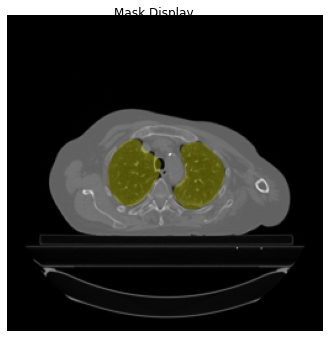

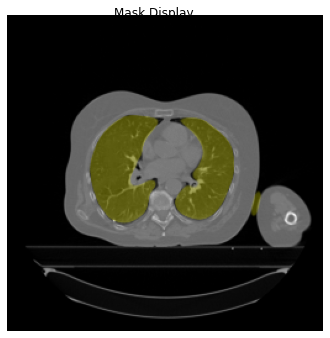

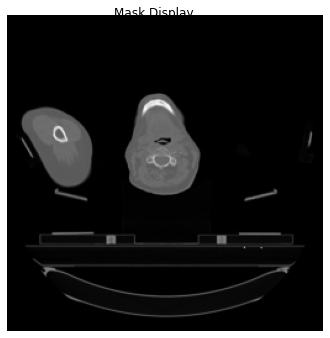

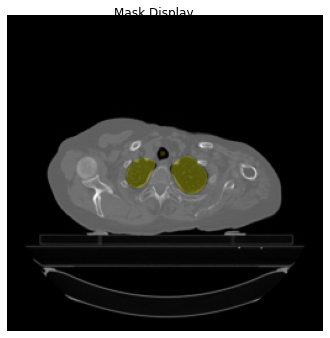

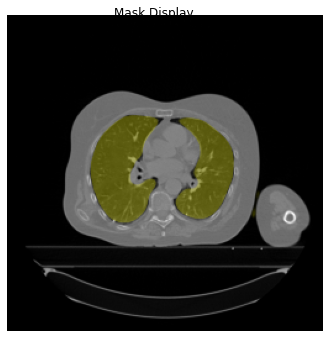

In [28]:
ims = numpy.split(valX[10:80:16,...,0],5)
masks = numpy.split(predictions2[10:80:16,...,0],5)
for im,mask in zip(ims,masks):
    display_mask(im[0],mask[0])

Now that you know the functional API, you can make any graph you like, train it, and use it! Once you've mastered the syntax and conceptual understanding of how to connect layers, you are only limited by your imagination as far as what kind of network you can build.

## End of Segmentation Example. Happy deep learning!

## Answers to Questions
    
#### 1- What could be another use for having multiple input channels?

In MRI, multiple sequences are usually acquired. It might take some resampling of the data, but you could use multiple sequences as different channels, for example, T1, T2, and 2-point Dixon images. Including more channels in your inputs almost always results in better performance for a deep learning model.

#### 2- What techniques or strategies can be used to mitigate issues with overfitting?

The best solution is to use more data. That is rarely a possible solution in medical imaging, so there are some alternatives.
1. Use data augmentation to synthesize extra data
2. Reduce the size or complexity of the network
3. Introduce regularization. This can include dropout, batch normalization, or L1/L2 regularization

#### 3- Can you explain the errors made by the deep learning model?

No! It's really difficult to explain or understand exactly what is going on inside a CNN. There's simply too many parameters involved to be able to pick apart what each one is doing. That's why training always needs validation- it's the only way to check that our model is really learning something useful.

#### 4- How can the validation loss be lower than the training loss?

It generally isn't, because the model learns from the training data and not the validation data. Only in contrived scenarios could the model actually perform better on the validation data than training. However, sometimes you will see lower validation loss. The explanations could be:
* The model has equivalent performance on training and validation, and slight random differences make the validation loss slightly lower
* A quirk of Keras. This is how Keras evaluates losses during training:
    1. Calculate loss of each training batch during epoch
    2. Average these losses together at end of epoch. This is the epoch's training loss
    3. Calculate total validation loss at end of epoch.
    
If a model learns very quickly (frequent in the first few epochs) then the performance of the model at the end of the epoch, when it evaluates the validation data, will better than the average performance during the entire epoch.